In [47]:
import numpy as np # for mathematical calculations
import pandas as pd
from datetime import datetime # to access datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, mean_squared_error, r2_score
from sklearn.metrics import auc, precision_recall_curve, f1_score, classification_report, roc_curve, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.tree import DecisionTreeClassifier, plot_tree


# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # for interactive plotting
import plotly.graph_objects as go # for interactive plotting

# warnings
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [48]:
import os
from google.colab import drive

In [49]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/DSO 530'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
train_df = pd.read_csv(os.path.join(path,'option_train.csv'), index_col = 'Unnamed: 0')
train_df.head()

,Value,S,K,tau,r,BS
1,348.500,1394.46,1050,0.128767,0.0116,Under
2,149.375,1432.25,1400,0.679452,0.0113,Under
3,294.500,1478.90,1225,0.443836,0.0112,Under
4,3.375,1369.89,1500,0.117808,0.0119,Over
5,84.000,1366.42,1350,0.298630,0.0119,Under


In [ ]:
#########################

# Features engineering

In [51]:
import math
train_df["moneyness"] = train_df.S/train_df.K #Currentassetvalue/Strikepriceofoption
train_df["abs_S-K"] = abs(train_df.S - train_df.K) # abs(Currentassetvalue - Strikepriceofoption)
train_df["intrinsic_value"] = train_df.apply(lambda row: max(row['S'] - row['K'], 0), axis=1) # max(Currentassetvalue - Strikepriceofoption,0)
train_df['tau_days'] = train_df['tau'] * 365.25
train_df["k*s"] = train_df.K*train_df.S

In [52]:
numerical = train_df.select_dtypes(include=['int64', 'float64']).columns
numerical

Index(['Value', 'S', 'K', 'tau', 'r', 'moneyness', 'abs_S-K',
       'intrinsic_value', 'tau_days', 'k*s'],
      dtype='object')

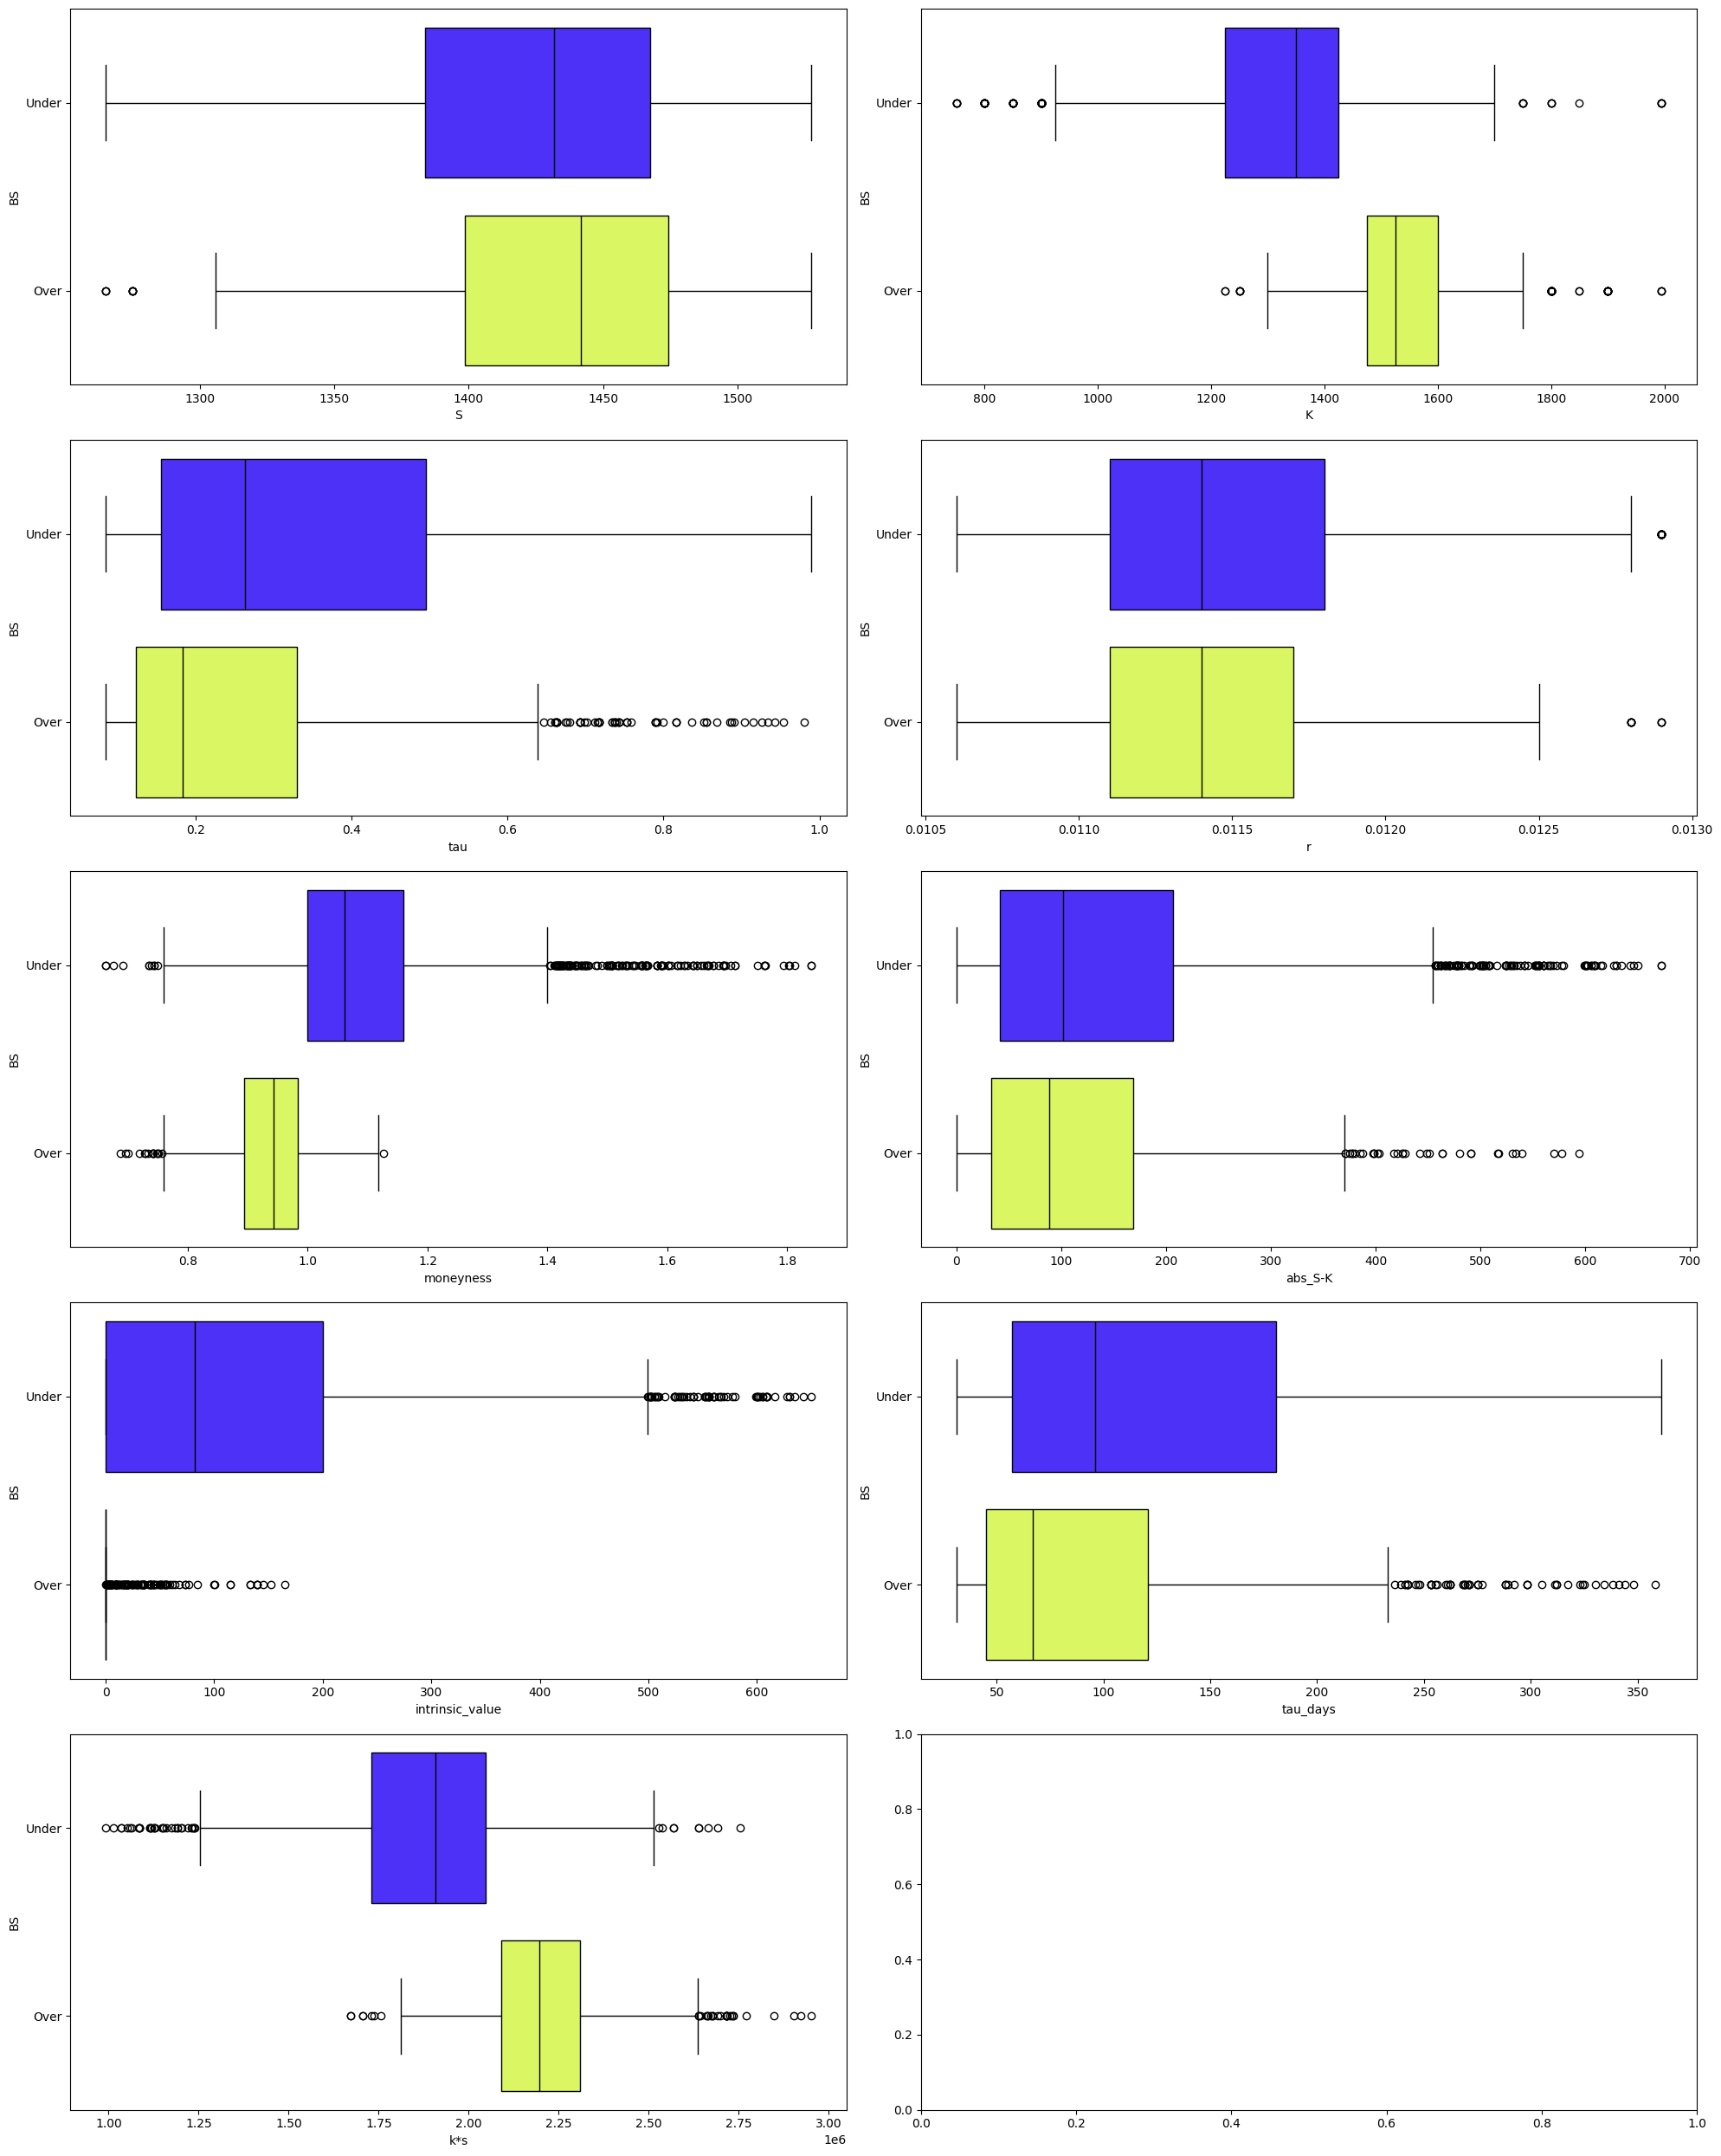

In [53]:
fig, axes = plt.subplots(5, 2, figsize=(20, 25))

for i, feature in enumerate(numerical[1:]):
    row = i // 2
    col = i % 2
    sns.boxplot(data=train_df, x=numerical[i+1], y='BS', hue='BS', ax=axes[row, col], palette=["#4D31F6", "#DAF662"], saturation=1, linecolor='black')

plt.tight_layout()

In [54]:
train_df['Response'] = np.where(train_df['BS'] == 'Over', 1, 0)

In [55]:
train_df.reset_index(drop=True, inplace= True)
train_df

,Value,S,K,tau,r,BS,moneyness,abs_S-K,intrinsic_value,tau_days,k*s,Response
0,348.500,1394.46,1050,0.128767,0.0116,Under,1.328057,344.46,344.46,47.032192,1464183.00,0
1,149.375,1432.25,1400,0.679452,0.0113,Under,1.023036,32.25,32.25,248.169863,2005150.00,0
2,294.500,1478.90,1225,0.443836,0.0112,Under,1.207265,253.90,253.90,162.110959,1811652.50,0
3,3.375,1369.89,1500,0.117808,0.0119,Over,0.913260,130.11,0.00,43.029452,2054835.00,1
4,84.000,1366.42,1350,0.298630,0.0119,Under,1.012163,16.42,16.42,109.074658,1844667.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,325.250,1465.15,1175,0.424658,0.0111,Under,1.246936,290.15,290.15,155.106164,1721551.25,0
4996,36.000,1480.87,1480,0.101370,0.0111,Over,1.000588,0.87,0.87,37.025342,2191687.60,1
4997,90.000,1356.56,1500,0.673973,0.0120,Under,0.904373,143.44,0.00,246.168493,2034840.00,0
4998,175.875,1333.36,1200,0.309589,0.0122,Under,1.111133,133.36,133.36,113.077397,1600032.00,0


In [115]:
# Split the dataset into features (X) and target variable (y)
X = train_df[['S', 'K', 'tau', 'r', 'moneyness', 'abs_S-K','intrinsic_value', 'tau_days','k*s']]
y = train_df['Response']

# Standardize numerical features
stdsc = StandardScaler()
X_scaled = stdsc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [57]:
feature_count = list(range(1, X_scaled.shape[1]))
feature_count

[1, 2, 3, 4, 5, 6, 7, 8]

In [58]:
kfolds = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True)

# Logistic Regression

In [59]:
# W/out Feature Selection
from sklearn.linear_model import LogisticRegression

# Build a logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_lr = cross_val_score(logistic_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("Logistic Regression: \n")
print("accuracies of 10-folds:",cv_scores_lr,"(mean classification error:",1-np.mean(cv_scores_lr),")")

Logistic Regression: 

accuracies of 10-folds: [0.916 0.896 0.89  0.902 0.894 0.904 0.884 0.894 0.872 0.884] (mean classification error: 0.10640000000000005 )


### Feature Selection

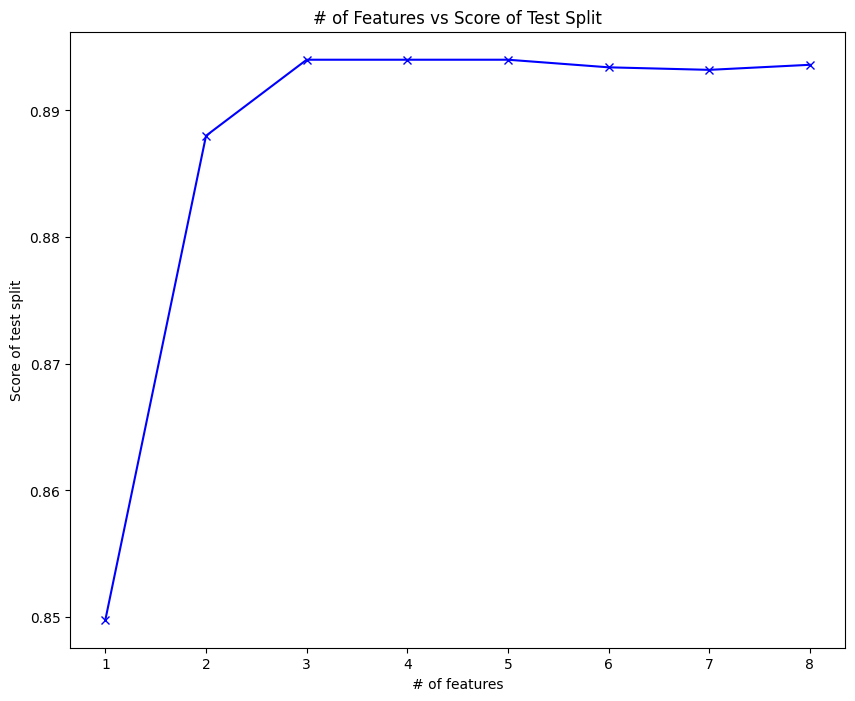

In [60]:
score_list = []

for k in feature_count:
  sfs_lr = sfs(logistic_model,k_features=k, forward=True, scoring='accuracy',cv=kfolds)
  sfs_lr.fit(X_scaled, y)
  feat_names_lr = list(sfs_lr.k_feature_names_)
  X_selected_lr = sfs_lr.transform(X_scaled)
  lr_accuracy = np.mean(cross_val_score(logistic_model, X_selected_lr, y, cv = kfolds, scoring = 'accuracy'))
  score_list.append(lr_accuracy)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [61]:
sfs_lr = sfs(logistic_model,k_features=3, forward=True, scoring='accuracy',cv=kfolds)
sfs_lr.fit(X_scaled, y)
feat_names_lr = list(sfs_lr.k_feature_names_)
print(feat_names_lr)

['K', 'tau', 'intrinsic_value']


In [62]:
# Perform cross-validation with accuracy scoring
cv_scores_lr = cross_val_score(logistic_model, X_scaled[feat_names_lr], y, cv=kfolds, scoring='accuracy')

print("Logistic Regression: \n")
print("accuracies of 10-folds:",cv_scores_lr,"(mean classification error:",1-np.mean(cv_scores_lr),")")

Logistic Regression: 

accuracies of 10-folds: [0.918 0.9   0.892 0.892 0.898 0.906 0.88  0.89  0.878 0.886] (mean classification error: 0.1060000000000001 )


### Hyperparameter Tuning

In [63]:
param_grid_lr = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

In [64]:
lr_sfs_CV = GridSearchCV(logistic_model, param_grid_lr, cv=kfolds, scoring='accuracy')

lr_sfs_CV.fit(X_scaled[feat_names_lr], y)

# Get best hyperparameters and score
print("Best parameter: ", lr_sfs_CV.best_params_)
print('Classification Error: ', 1-lr_sfs_CV.best_score_)

Best parameter:  {'C': 4.281332398719396, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}
Classification Error:  0.10539999999999983


# SVM

In [65]:
# W/out feature selection
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_svm = cross_val_score(svm_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("SVM: \n")
print("accuracies of 10-folds:",cv_scores_svm,"(mean classification error:",1-np.mean(cv_scores_svm),")")

SVM: 

accuracies of 10-folds: [0.922 0.92  0.908 0.902 0.902 0.906 0.906 0.906 0.894 0.908] (mean classification error: 0.09260000000000002 )


### Feature Selection

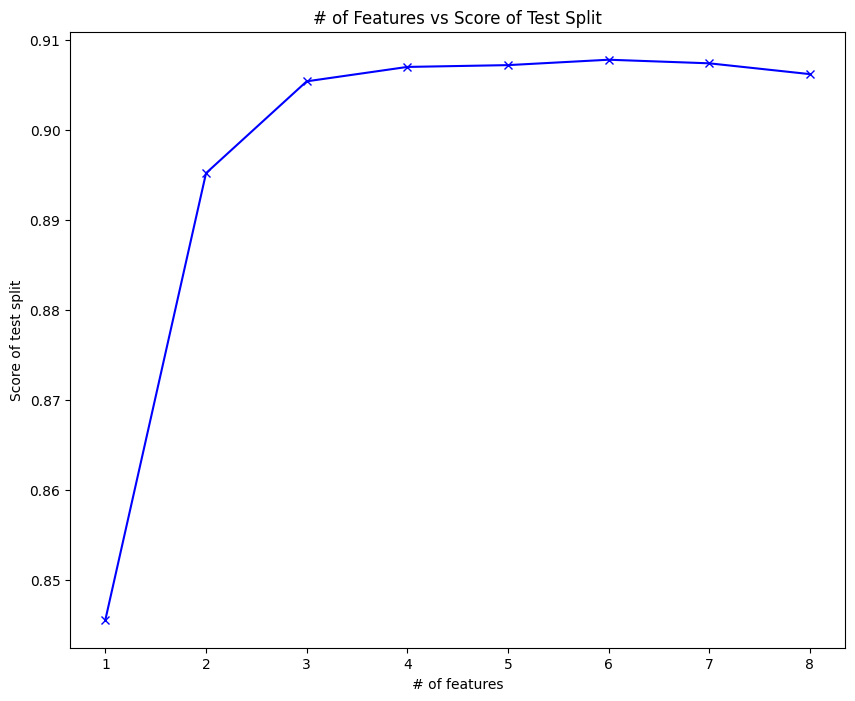

In [66]:
score_list = []

for k in feature_count:
  # svm_model = SVC(probability=True, random_state= 1234)
  sfs_svm = sfs(svm_model,k_features=k, forward=True, scoring='accuracy')
  sfs_svm.fit(X_scaled, y)
  feat_names_svm = list(sfs_svm.k_feature_names_)
  X_selected_svm = sfs_svm.transform(X_scaled)
  svm_accuracy = np.mean(cross_val_score(svm_model, X_selected_svm, y, cv = kfolds, scoring = 'accuracy'))
  score_list.append(svm_accuracy)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [67]:
sfs_svm = sfs(svm_model,k_features=6, forward=True, scoring='accuracy')
sfs_svm.fit(X_scaled, y)
feat_names_svm = list(sfs_svm.k_feature_names_)
print(feat_names_svm)

['S', 'K', 'tau', 'r', 'moneyness', 'abs_S-K']


In [68]:
# Perform cross-validation with accuracy scoring
cv_scores_svm = cross_val_score(svm_model, X_scaled[feat_names_svm], y, cv=kfolds, scoring='accuracy')

print("SVM: \n")
print("accuracies of 10-folds:",cv_scores_svm,"(mean classification error:",1-np.mean(cv_scores_svm),")")

SVM: 

accuracies of 10-folds: [0.922 0.922 0.91  0.902 0.906 0.906 0.898 0.912 0.894 0.906] (mean classification error: 0.09219999999999984 )


### Hyperparameter Tuning

In [69]:
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['rbf', 'poly', 'sigmoid','linear'],
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

In [70]:
svm_sfs_CV = GridSearchCV(svm_model, param_grid_svm, cv=kfolds, scoring='accuracy',n_jobs=-1)

svm_sfs_CV.fit(X_scaled[feat_names_svm], y)

# Get best hyperparameters and score
print("Best Hyperparameters:", svm_sfs_CV.best_params_)
print('Classification Error: ', 1-svm_sfs_CV.best_score_)

Best Hyperparameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Classification Error:  0.08499999999999996


# XGBoost

In [71]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_xgb = cross_val_score(xgb_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("XGBoost: \n")
print("accuracies of 10-folds:",cv_scores_xgb,"(mean classification error:",1-np.mean(cv_scores_xgb),")")

XGBoost: 

accuracies of 10-folds: [0.944 0.95  0.922 0.946 0.932 0.952 0.932 0.946 0.936 0.938] (mean classification error: 0.06020000000000003 )


### Hyperparameter Tuning

In [72]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition
}

In [73]:
xgb_CV = GridSearchCV(xgb_model, param_grid_xgb, cv=kfolds, scoring='accuracy',n_jobs=-1)

xgb_CV.fit(X_scaled, y)

# Get best hyperparameters and score
print("Best Hyperparameters:", xgb_CV.best_params_)
print('Classification Error: ', 1-xgb_CV.best_score_)

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Classification Error:  0.05579999999999996


Text(0.5, 0, 'XGBoost Feature Importance')

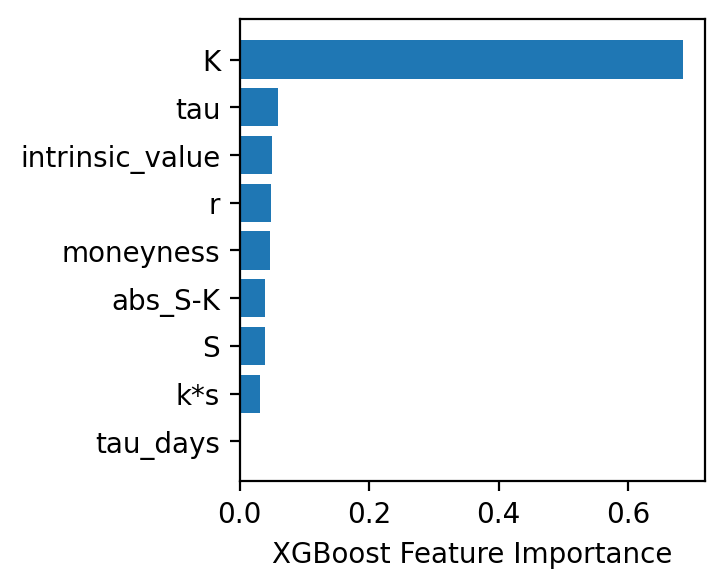

In [74]:
## plot the top 10 features in terms of Gini index
xgb = xgb_CV.best_estimator_

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3), dpi=200)
sorted_idx = xgb.feature_importances_.argsort() ## remove [-10:] to get a plot for all features
plt.barh(X_scaled.columns.values[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

# KNN

In [75]:
# W/out Feature Selection
knn_model = KNeighborsClassifier()
knn_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("KNN: \n")
print("accuracies of 10-folds:",cv_scores_knn,"(mean classification error:",1-np.mean(cv_scores_knn),")")

KNN: 

accuracies of 10-folds: [0.914 0.918 0.93  0.912 0.908 0.91  0.912 0.908 0.914 0.918] (mean classification error: 0.08560000000000001 )


### Feature Engineering

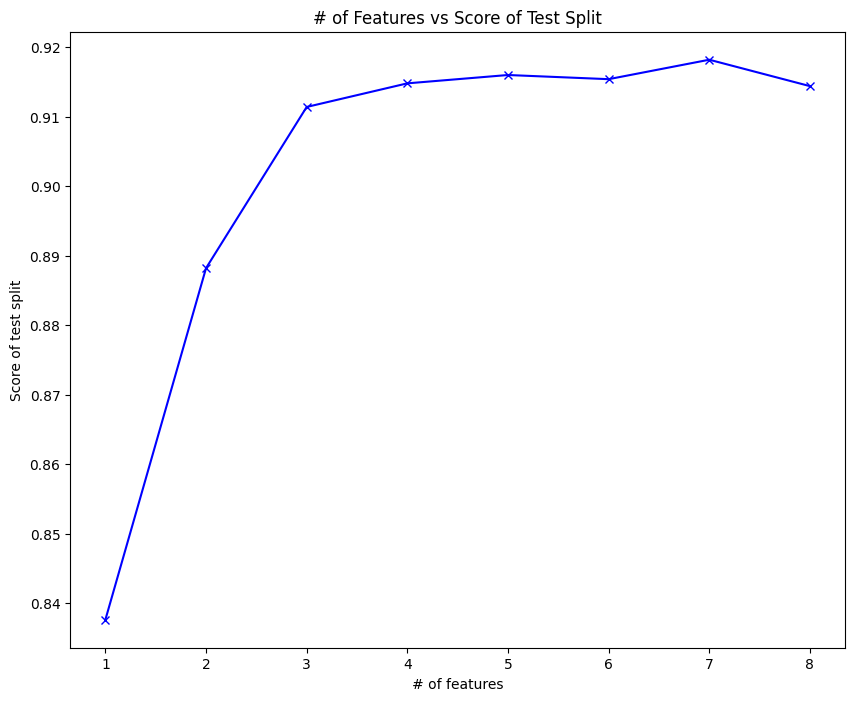

In [76]:
score_list = []

for k in feature_count:
  knn_sfs = sfs(KNeighborsClassifier(), k_features = k, forward = 'True', scoring = 'accuracy', cv = kfolds)
  knn_sfs.fit(X_scaled, y) # fit on training set to choose best features
  feat_names = list(knn_sfs.k_feature_names_)
  x_selected = knn_sfs.transform(X_scaled)
  knn_accuracy = np.mean(cross_val_score(KNeighborsClassifier(), x_selected, y, cv = kfolds, scoring = 'accuracy'))
  score_list.append(knn_accuracy)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of test split')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [77]:
sfs_knn = sfs(KNeighborsClassifier(), k_features = 7, forward = True, scoring = 'accuracy')
sfs_knn.fit(X_scaled, y)
feat_names_KNN = list(sfs_knn.k_feature_names_)
print(feat_names_KNN)

['S', 'K', 'tau', 'r', 'moneyness', 'tau_days', 'k*s']


In [78]:
knn_sfs_CV = GridSearchCV(KNeighborsClassifier(),
                          param_grid = {'n_neighbors': list(range(2, 41)),
                                        'metric': ['euclidean', 'manhattan', 'hamming', 'minkowski']},
                          scoring = 'accuracy',  cv = kfolds)

knn_sfs_CV.fit(X_scaled[feat_names_KNN], y)
print("Best parameter: ", knn_sfs_CV.best_params_)
print('Classification erorr: ', 1 - knn_sfs_CV.best_score_)

Best parameter:  {'metric': 'manhattan', 'n_neighbors': 5}
Classification erorr:  0.08119999999999994


In [ ]:
################################

# Decision Tree

In [79]:
# W/out Feature Selection
tree_model = DecisionTreeClassifier()
tree_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_tree = cross_val_score(tree_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("Decision Tree: \n")
print("accuracies of 10-folds:",cv_scores_tree,"(mean classification error:",1-np.mean(cv_scores_tree),")")

Decision Tree: 

accuracies of 10-folds: [0.906 0.908 0.904 0.926 0.912 0.91  0.906 0.932 0.924 0.908] (mean classification error: 0.08640000000000003 )


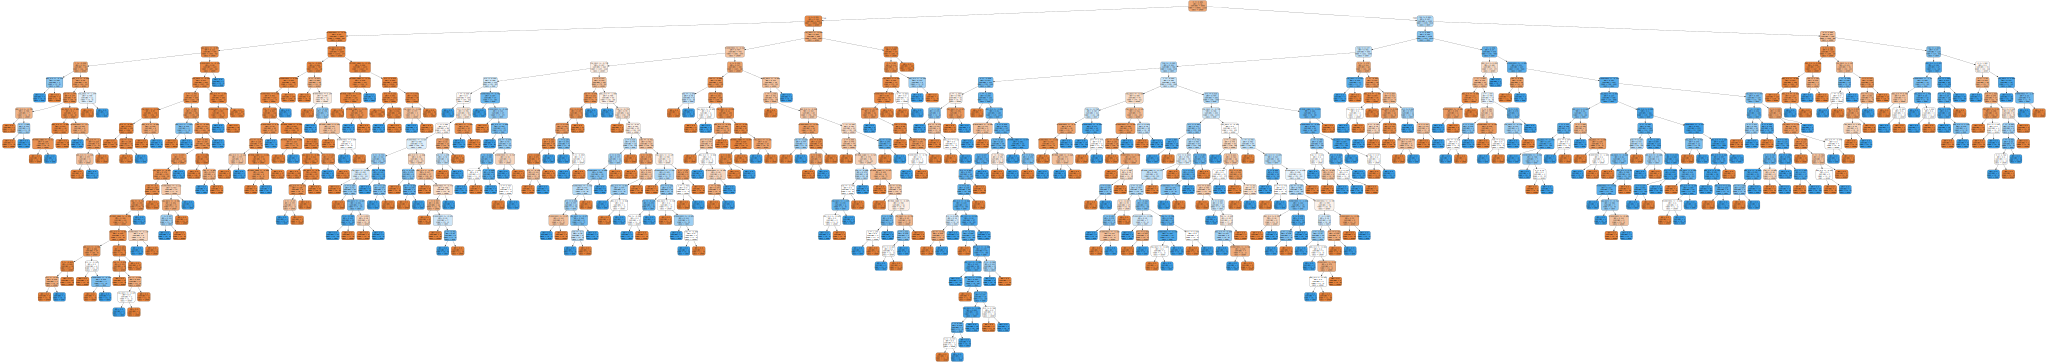

In [80]:
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import export_graphviz

#plot tree
dot_data = export_graphviz(tree_model, out_file = None, feature_names = X_scaled.columns, class_names = ["Under", "Over"],
                           rounded = True, filled = True)

plot = graphviz.Source(dot_data)
plot

### Feature Engineering

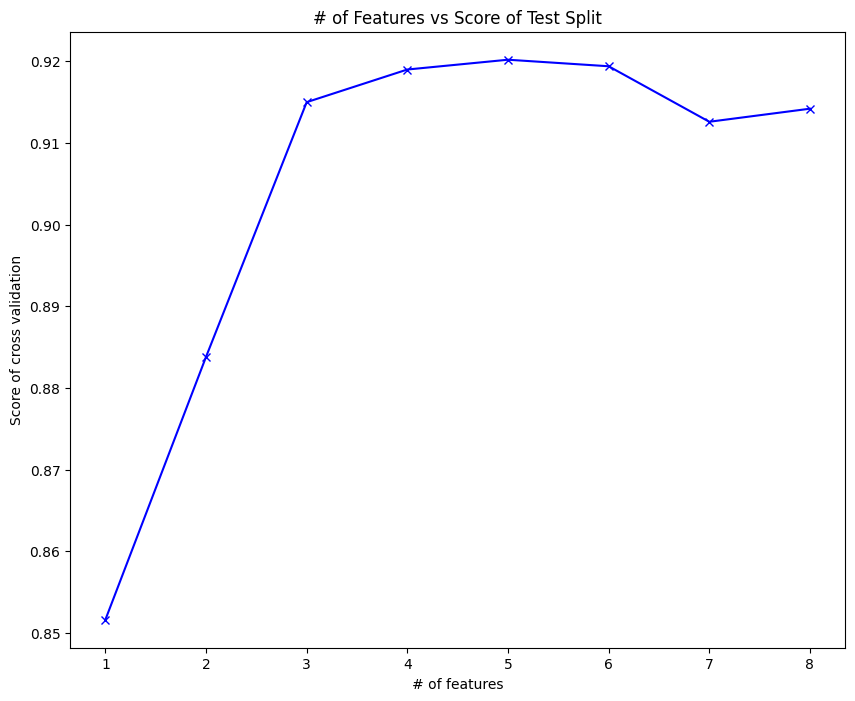

In [81]:
score_list = []

for k in feature_count:
  tree_sfs = sfs(DecisionTreeClassifier(), k_features = k, forward = 'True', scoring = 'accuracy', cv = kfolds)
  tree_sfs.fit(X_scaled, y) # fit on training set to choose best features
  feat_names = list(tree_sfs.k_feature_names_)
  x_selected = tree_sfs.transform(X_scaled)
  tree_accuracy = np.mean(cross_val_score(DecisionTreeClassifier(), x_selected, y, cv = kfolds, scoring = 'accuracy'))
  score_list.append(tree_accuracy)

plt.figure(figsize=(10,8))
plt.plot(feature_count, score_list, 'bx-')
plt.xlabel('# of features')
plt.ylabel('Score of cross validation')
plt.title('# of Features vs Score of Test Split')
plt.show()

In [84]:
sfs_tree = sfs(DecisionTreeClassifier(), k_features = 6, forward = True, scoring = 'accuracy')
sfs_tree.fit(X_scaled, y)
feat_names_tree = list(sfs_tree.k_feature_names_)
print(feat_names_tree)

['S', 'K', 'tau', 'r', 'intrinsic_value', 'k*s']


In [86]:
# Range of parameters to search over
params = {'max_depth': range(1, 11),
          'min_samples_split': range(1, 41)}

tree_sfs_CV = GridSearchCV(DecisionTreeClassifier(), param_grid=params, scoring = 'accuracy', cv = kfolds)
tree_sfs_CV.fit(X_scaled[feat_names_tree], y)

print("Best parameter: ", tree_sfs_CV.best_params_)
print('Classification error: ', 1 - tree_sfs_CV.best_score_)

Best parameter:  {'max_depth': 10, 'min_samples_split': 3}
Classification error:  0.09499999999999997


In [ ]:
##################################

# Random Forest

In [87]:
forest_model = RandomForestClassifier()
forest_model.fit(X_scaled, y)

# Perform cross-validation with accuracy scoring
cv_scores_forest = cross_val_score(forest_model, X_scaled, y, cv=kfolds, scoring='accuracy')

print("Random Forest: \n")
print("accuracies of 10-folds:",cv_scores_forest,"(mean classification error:",1-np.mean(cv_scores_forest),")")

Random Forest: 

accuracies of 10-folds: [0.932 0.946 0.92  0.94  0.916 0.942 0.932 0.944 0.936 0.93 ] (mean classification error: 0.06620000000000004 )


### Hyperparameter Tuning

In [88]:
# Range of parameters to search over
params = {'n_estimators': [100, 200, 300, 400, 500, 600],
          'max_features': ["sqrt", "log2", None, 3, 5, 7, 9]}

forest_sfs_CV = RandomizedSearchCV(RandomForestClassifier(), params, scoring = 'accuracy', cv = kfolds)
forest_sfs_CV.fit(X_scaled, y)
print("Best parameter: ", forest_sfs_CV.best_params_)
print('Classification error: ', 1 - forest_sfs_CV.best_score_)

Best parameter:  {'n_estimators': 200, 'max_features': 3}
Classification error:  0.06540000000000001


Text(0.5, 0, 'Random Forest Feature Importance')

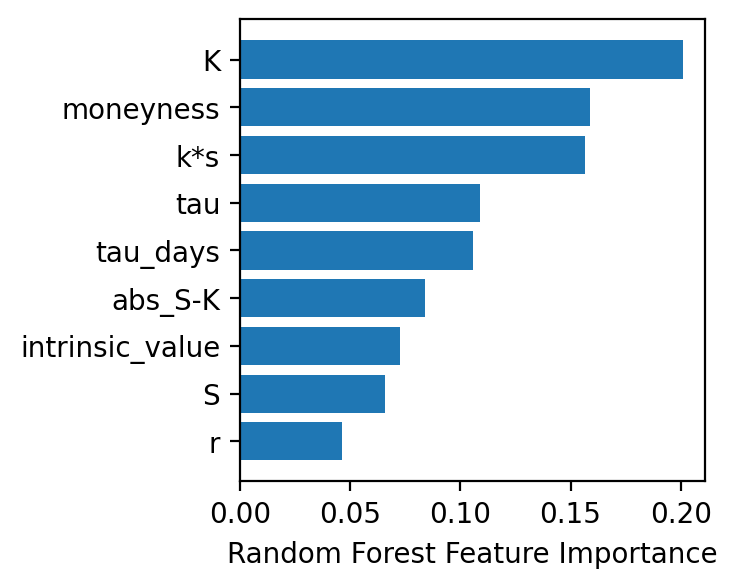

In [89]:
## plot the top 10 features in terms of Gini index
rfc = forest_sfs_CV.best_estimator_

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3), dpi=200)
sorted_idx = rfc.feature_importances_.argsort() ## remove [-10:] to get a plot for all features
plt.barh(X_scaled.columns.values[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
##################################

# Final Prediction

In [116]:
test_df = pd.read_csv(os.path.join(path, 'option_test_nolabel.csv'), index_col = 'Unnamed: 0')
test_df

,S,K,tau,r
1,1409.28,1325,0.126027,0.0115
2,1505.97,1100,0.315068,0.0110
3,1409.57,1450,0.197260,0.0116
4,1407.81,1250,0.101370,0.0116
5,1494.50,1300,0.194521,0.0110
...,...,...,...,...
496,1514.09,1200,0.301370,0.0109
497,1359.15,1500,0.260274,0.0119
498,1396.93,1410,0.156164,0.0117
499,1436.51,1475,0.463014,0.0114


In [117]:
import math
test_df["moneyness"] = test_df.S/test_df.K #Currentassetvalue/Strikepriceofoption
test_df["abs_S-K"] = abs(test_df.S - test_df.K) # abs(Currentassetvalue - Strikepriceofoption)
test_df["intrinsic_value"] = test_df.apply(lambda row: max(row['S'] - row['K'], 0), axis=1) # max(Currentassetvalue - Strikepriceofoption,0)
test_df['tau_days'] = test_df['tau'] * 365.25
test_df["k*s"] = test_df.K*test_df.S

In [118]:
test_df

,S,K,tau,r,moneyness,abs_S-K,intrinsic_value,tau_days,k*s
1,1409.28,1325,0.126027,0.0115,1.063608,84.28,84.28,46.031507,1867296.00
2,1505.97,1100,0.315068,0.0110,1.369064,405.97,405.97,115.078767,1656567.00
3,1409.57,1450,0.197260,0.0116,0.972117,40.43,0.00,72.049315,2043876.50
4,1407.81,1250,0.101370,0.0116,1.126248,157.81,157.81,37.025342,1759762.50
5,1494.50,1300,0.194521,0.0110,1.149615,194.50,194.50,71.048630,1942850.00
...,...,...,...,...,...,...,...,...,...
496,1514.09,1200,0.301370,0.0109,1.261742,314.09,314.09,110.075342,1816908.00
497,1359.15,1500,0.260274,0.0119,0.906100,140.85,0.00,95.065068,2038725.00
498,1396.93,1410,0.156164,0.0117,0.990730,13.07,0.00,57.039041,1969671.30
499,1436.51,1475,0.463014,0.0114,0.973905,38.49,0.00,169.115753,2118852.25


In [119]:
x_test = test_df

x_test_scaled = stdsc.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns)

In [120]:
x_test_scaled

,S,K,tau,r,moneyness,abs_S-K,intrinsic_value,tau_days,k*s
0,-0.309816,-0.262038,-0.872064,0.072267,0.032206,-0.411895,-0.089865,-0.872064,-0.332850
1,1.415377,-1.565163,-0.054275,-1.042965,2.078861,2.184971,2.408314,-0.054275,-1.122771
2,-0.304642,0.461920,-0.563912,0.295313,-0.580808,-0.765877,-0.744367,-0.563912,0.329065
3,-0.336044,-0.696413,-0.978732,0.295313,0.451918,0.181682,0.481154,-0.978732,-0.735941
4,1.210723,-0.406830,-0.575764,-1.042965,0.608487,0.477864,0.766081,-0.575764,-0.049635
...,...,...,...,...,...,...,...,...,...
495,1.560258,-0.985997,-0.113535,-1.266011,1.359769,1.443263,1.694792,-0.113535,-0.521730
496,-1.204261,0.751504,-0.291315,0.964453,-1.023145,0.044771,-0.744367,-0.291315,0.309754
497,-0.530171,0.230254,-0.741692,0.518360,-0.456094,-0.986743,-0.744367,-0.741692,0.050905
498,0.176036,0.606712,0.585733,-0.150779,-0.568829,-0.781538,-0.744367,0.585733,0.610113


In [121]:
y_pred = xgb.predict(x_test_scaled)
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

In [122]:
# Count occurrences of each unique value
counts = np.bincount(y_pred)

# The count of 0s is counts[0] and the count of 1s is counts[1]
count_0 = counts[0]
count_1 = counts[1]

print("Number of 0s:", count_0)
print("Number of 1s:", count_1)

Number of 0s: 397
Number of 1s: 103


In [123]:
y_pred_df = pd.DataFrame(y_pred, columns=['BS'])
y_pred_df

,BS
0,0
1,0
2,0
3,0
4,0
...,...
495,0
496,0
497,0
498,0


In [124]:
# Save DataFrame to CSV file
y_pred_df.to_csv('/content/drive/My Drive/DSO 530/Submission/classification.csv', index=False)